In [252]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

In [332]:
def read_output(filename,ragged=False,even_features=False):
    U=[]
    G=[]
    with open(filename) as file:
        L=file.readlines()
        for l in L:
            m = re.match(R"\[((?:\d,)+)\]: (\d)",l)
            if m:
                S=m.group(1)
                U.append(np.fromstring(S,dtype=np.int32,sep=','))
                G.append(int(m.group(2)))
    G=np.array(G)
    X=pd.DataFrame()
    if ragged:
        X["n"]=list(map(np.sum,U))
        X["n mod 2"] = X["n"] % 2
        X["C[0]"] = list(map(lambda x:x[0],U))
        X["C[0]==n-2"] =  X["C[0]"] == X["n"] -2
        X["C[0]==n"] =  X["C[0]"] == X["n"]
        if even_features:
            X["C[K/2]"] = list(map(lambda x:x[len(x)//2],U))
            X["C[K/2] mod 2"] = X["C[K/2]"] %2
            X["C[K/2]==n-2"] = X["C[K/2]"] == X["n"] -2
            X["C[K/2]==n"] = X["C[K/2]"] == X["n"] 
            X["C[K/2]==n/2"] = X["C[K/2]"] == X["n"] //2
            X["C[K/2]==0"] = X["C[K/2]"] == 0
    else:
        U=np.stack(U)
        X["n"]=np.sum(U,axis=-1)
        X["n mod 2"] = X["n"] % 2
        X["C[0]"] = U[:,0]
        X["C[0] == n-2"] = U[:,0] == X["n"] -2
        X["C[0] == n"] = U[:,0] == X["n"]
        if U.shape[1] % 2==0:
            X["C[K/2]"] = U[:,U.shape[1]//2]
            X["C[K/2] mod 2"] = X["C[K/2]"] %2
            X["C[K/2] == n-2"] = X["C[K/2]"] == X["n"] -2
            X["C[K/2] == n"] = X["C[K/2]"] == X["n"] 
            X["C[K/2] == n/2"] = X["C[K/2]"] == X["n"] //2
    return U,X,G
U,X,G=read_output("output.txt",ragged=True,even_features=True)

In [347]:
from sklearn import tree
D=X.copy()
D["G"]=G
clf = tree.DecisionTreeClassifier(max_depth=4,criterion="entropy")
selected_features=["C[K/2] mod 2","n mod 2","C[0]==n-2","C[0]==n"]
D=D[(D["C[K/2]"]==6)]
clf.fit(D[selected_features],D["G"])

DecisionTreeClassifier(criterion='entropy', max_depth=4)

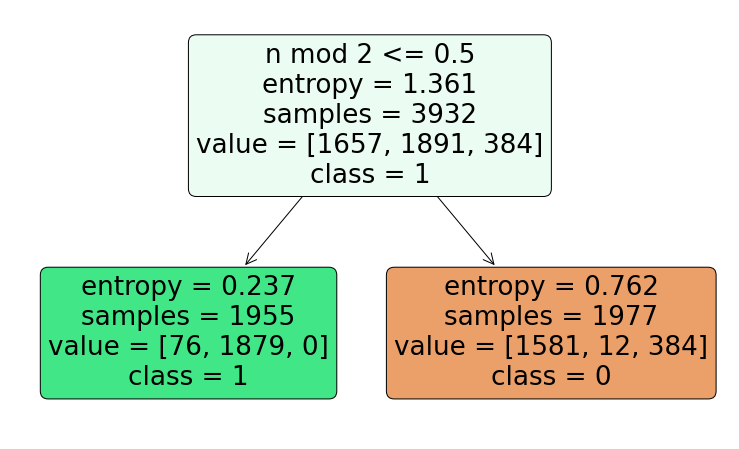

In [348]:
fig,ax=plt.subplots(1,1,figsize=(13,8))
tree.plot_tree(clf,ax=ax,feature_names=selected_features,class_names=["0","1","2"],filled=True,rounded=True)
fig.savefig("tree.png",dpi=300)

In [175]:
mask=(X["C[0]"]<=2) & (X["C[0]==n-2"]) & (X["n mod 2"]==1)

0

In [177]:
G[mask]

array([0, 2, 0, 2, 0, 0])

In [248]:
X[selected_features]

,C[K/2] mod 2,n mod 2,C[0]==n-2,C[0]==n
0,0,0,False,False
1,0,1,False,False
2,0,0,False,False
3,0,0,False,False
4,0,1,False,False
...,...,...,...,...
4619,0,1,True,False
4620,0,1,False,False
4621,1,0,False,False
4622,0,1,False,False


,C[K/2] mod 2,n mod 2,C[0] == n-2,C[0] == n
0,0,0,False,False
1,0,1,False,False
2,0,0,False,False
3,0,0,False,False
4,0,1,False,False
...,...,...,...,...
4619,0,1,True,False
4620,0,1,False,False
4621,1,0,False,False
4622,0,1,False,False


In [321]:
n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold
values = clf.tree_.value

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print(
    "The binary tree structure has {n} nodes and has "
    "the following tree structure:\n".format(n=n_nodes)
)
for i in range(n_nodes):
    if is_leaves[i]:
        print(
            "{space}node={node} is a leaf node with value={value}.".format(
                space=node_depth[i] * "\t", node=i, value=values[i]
            )
        )
    else:
        print(
            "{space}node={node} is a split node with value={value}: "
            "go to node {left} if X[:, {feature}] <= {threshold} "
            "else to node {right}.".format(
                space=node_depth[i] * "\t",
                node=i,
                left=children_left[i],
                feature=feature[i],
                threshold=threshold[i],
                right=children_right[i],
                value=values[i],
            )
        )

The binary tree structure has 5 nodes and has the following tree structure:

node=0 is a split node with value=[[2.9874e+04 3.0011e+04 2.5000e+01]]: go to node 1 if X[:, 1] <= 0.5 else to node 2.
	node=1 is a leaf node with value=[[    0. 30011.     0.]].
	node=2 is a split node with value=[[2.9874e+04 0.0000e+00 2.5000e+01]]: go to node 3 if X[:, 2] <= 0.5 else to node 4.
		node=3 is a leaf node with value=[[29874.     0.     0.]].
		node=4 is a leaf node with value=[[ 0.  0. 25.]].
